## Language translation with Torchtext!! ## 

Seq2Seq network with torchtext

https://pytorch.org/tutorials/beginner/torchtext_translation.html

In [1]:
import sys#
stdout = sys.stdout#

import random
from typing import Tuple

import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import io
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
import math
import time

sys.stdout = stdout #these lines are a workaround to fix an issue where no prints were showing

In [2]:
print('f')

f


In [3]:

url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = get_tokenizer('spacy', language='en')

def build_vocab(filepath, tokenizer):
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            counter.update(tokenizer(string_))
    
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

def data_process(filepaths):
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    src_max_length = 0
    tgt_max_length = 0
    data = []
    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)], dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)], dtype=torch.long)
        data.append((de_tensor_, en_tensor_))
        
        if de_tensor_.size(0) > src_max_length:
            src_max_length = de_tensor_.size(0)
            
        if en_tensor_.size(0) > tgt_max_length:
            tgt_max_length = en_tensor_.size(0)
        
    return data, src_max_length, tgt_max_length

train_data, trsl, trtl = data_process(train_filepaths)
val_data, vsl, vtl = data_process(val_filepaths)
test_data, tesl, tetl = data_process(test_filepaths)
print('f')

f


In [4]:
# We calculate the sentence with max_length
candidates_lengths = [trsl, trtl, vsl, vtl, tesl, tetl]
print(max(candidates_lengths))
MAX_LENGTH = max(candidates_lengths) + 2
print(MAX_LENGTH)
print('f')

45
47
f


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('f')

f


In [6]:
BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
    de_batch, en_batch, en_batch_out = [], [], []
    a = 0
    for (de_item, en_item) in data_batch:
        de_extra = MAX_LENGTH - (de_item.size(0) + 2)
        en_extra = MAX_LENGTH - (en_item.size(0) + 2)
        en_inp_extra = MAX_LENGTH - (en_item.size(0) + 1)
        
        de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX]), torch.full((de_extra,), PAD_IDX)], dim=0))
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX]), torch.full((en_extra,), PAD_IDX)], dim=0))
        en_batch_out.append(torch.cat([en_item, torch.tensor([EOS_IDX]), torch.full((en_inp_extra,), PAD_IDX)], dim=0)) # Target input 
    de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
    en_batch_out = pad_sequence(en_batch_out, padding_value=PAD_IDX)
    return de_batch, en_batch, en_batch_out

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
print('f')

f


In [7]:
german_id_to_text = lambda x: [de_vocab.itos[t] for t in x]

In [8]:
english_id_to_text = lambda x: [en_vocab.itos[t] for t in x]

## Now, we create the Seq2Seq model ##

The Seq2Seq model is an encoder-decoder model

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, gru_layers):
        super(EncoderRNN, self).__init__()
        self.gru_layers = gru_layers
        
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, gru_layers)

    def forward(self, x, hidden):
        batch_size = x.size()[0]
#         print("X :", x.shape)
        embedded = self.embedding(x)
#         print("EMBEDD: ", embedded.shape)
        embedded = embedded.view(1, batch_size, -1)
#         print("EMBEDD VIEW: ", embedded.shape)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(self.gru_layers, batch_size, self.hidden_size, device=device)
print('f')

f


### Attention Decoder ###
If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few

In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, gru_layers, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.gru_layers = gru_layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, gru_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, hidden, encoder_outputs):
        batch_size = x.size()[0]
        # Embedding: a simple lookup table that stores embeddings of a fixed dictionary and size.
        # This module is often used to store word embeddings and retrieve them using indices. 
        # The input to the module is a list of indices, and the output is the corresponding word embeddings
#         print("INPUT SHAPE: ", x.shape)
#         print(batch_size)
        embedded = self.embedding(x)
#         print("EMBEDD: ", embedded.shape)
        embedded = embedded.view(1, batch_size, -1)
#         print("EMBEDD VIEW: ", embedded.shape)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # torch.bmm performs a batch matrix-matrix product of matrices stored in input and mat2.
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self, batch_size):
        return torch.zeros(self.gru_layers, batch_size, self.hidden_size, device=device)
print('f')

f


### We  create the classic train/evaluate loop ###

For this task, we have something called **teacher_forcing_ratio**, this helps us vary between giving the network the possibility to try to translate using its own previous prediction (no teacher forcing), or we use the known target for it

In [11]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, target_tensor_out, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, initHIDDEN = True):
    
    if initHIDDEN:
        encoder_hidden = encoder.initHidden(input_tensor.size(1))
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

    loss = 0
    
    # We run the input sequence through the encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
#         print(encoder_output.shape)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.full((target_tensor.size(1),), BOS_IDX, device=device)
#     decoder_input = torch.tensor([[BOS_IDX], target_tensor.size(1)], device=device)

#     print(decoder_input.shape)
    decoder_hidden = encoder_hidden
    decoded_words = []
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoded_words.append(english_id_to_text(topi[0]))
            loss += criterion(decoder_output, target_tensor_out[di])
            if di + 1 < target_length:
                decoder_input = target_tensor[di + 1]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoded_words.append(english_id_to_text(topi[0]))
            decoder_input = topi.detach()  # detach from history as input
#             print(target_tensor[di].shape)
            loss += criterion(decoder_output, target_tensor_out[di])

#     print(decoded_words)
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length
print('f')

f


In [12]:
def evaluate(encoder, decoder, input_tensor):
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        encoder_hidden = encoder.initHidden(input_tensor.size(1))
        input_length = input_tensor.size(0)

        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
        
        # We run the input sequence through the encoder
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        
#         print(encoder_outputs[:1])
        decoder_input = torch.full((input_tensor.size(1),), BOS_IDX, device=device)
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

        for di in range(MAX_LENGTH):
#             print(decoder_input)
#             print(decoder_input.shape)
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.topk(1)
            if topi.item() == EOS_IDX:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(english_id_to_text(topi))
#             print(decoded_words)
            decoder_input = topi.detach()
          
        return decoded_words, decoder_attentions[:di + 1]
print('f')

f


In [13]:
# Helper methods

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s' % (asMinutes(s))

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [15]:
def trainIters(encoder, decoder, epochs,initHIDDEN = True, print_every=50, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    PAD_IDX = en_vocab.stoi['<pad>']
    criterion = nn.NLLLoss(ignore_index=PAD_IDX)

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    for epoch in range(0, epochs +1):
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every
        print("-----------------------")
        print("EPOCH: ", epoch, " out of ", epochs, " epochs")
        print("-----------------------")
        for batch_counter, (src, trg, trg_output) in enumerate(train_iter):
            src, trg, trg_output = src.to(device), trg.to(device), trg_output.to(device)
            src_ = src.permute(1,0)
            trg_ = trg.permute(1,0)
            trg_output_ = trg_output.permute(1, 0)
            
            # Uncomment to go 1 by 1 manual unbatch version (preferably simply set batch = 1)
#             for j in range(len(src_)):
#                 loss = train(src_[j].unsqueeze(dim=1), trg_[j].unsqueeze(dim=1), trg_output_[j].unsqueeze(dim=1), encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
#                 print_loss_total += loss
#                 plot_loss_total += loss
                
            loss = train(src, trg, trg_output, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, initHIDDEN)
            print_loss_total += loss
            plot_loss_total += loss

    #     training_pairs = [tensorsFromPair(random.choice(pairs))
    #                       for i in range(n_iters)]

            batch_counter += 1

            if batch_counter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, batch_counter / len(train_iter)),
                                             batch_counter, batch_counter/ len(train_iter) * 100, print_loss_avg))

            if batch_counter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses)
print('f')

f


The model has 6,497,792 trainable parameters
The model has 7,295,367 trainable parameters
-----------------------
EPOCH:  0  out of  5  epochs
-----------------------
5m 27s (50 22%) 4.4037
11m 16s (100 44%) 3.3256
17m 7s (150 66%) 3.2630
23m 2s (200 88%) 2.9897
-----------------------
EPOCH:  1  out of  5  epochs
-----------------------
32m 7s (50 22%) 3.0885
38m 1s (100 44%) 2.9875
44m 0s (150 66%) 2.9231
50m 2s (200 88%) 2.8418
-----------------------
EPOCH:  2  out of  5  epochs
-----------------------
58m 55s (50 22%) 2.8222
65m 4s (100 44%) 2.7374
71m 23s (150 66%) 2.7423
77m 37s (200 88%) 2.8127
-----------------------
EPOCH:  3  out of  5  epochs
-----------------------
87m 14s (50 22%) 2.7855
93m 47s (100 44%) 2.6796
100m 18s (150 66%) 2.7241
106m 53s (200 88%) 2.7150
-----------------------
EPOCH:  4  out of  5  epochs
-----------------------
115m 30s (50 22%) 2.6404
121m 17s (100 44%) 2.7987
126m 39s (150 66%) 2.7943
131m 17s (200 88%) 2.6606
-----------------------
EPOCH:  

<Figure size 432x288 with 0 Axes>

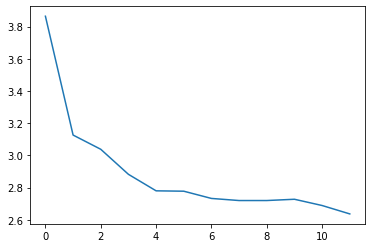

In [16]:
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(en_vocab)
hidden_size = 256

encoder1 = EncoderRNN(INPUT_DIM, hidden_size, 4).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, OUTPUT_DIM, 4, dropout_p=0.1).to(device)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(encoder1):,} trainable parameters')
print(f'The model has {count_parameters(attn_decoder1):,} trainable parameters')

trainIters(encoder1, attn_decoder1, epochs = 5, print_every=50)

In [17]:
# Randomly evaluate
def evaluateRandomly(encoder, decoder, n=10):
    for _, (src, trg, tgt_output) in enumerate(test_iter):
        for i in range(n):
#             print(src.shape)
            src_ = src.permute(1,0)
            trg_ = trg.permute(1,0)
#             print(src_[i])
#             print(src_[i].unsqueeze(dim=1).shape)

            src_ = src_[i]
            trg_ = trg_[i]
            print('>', german_id_to_text(src_))
            print('=', english_id_to_text(trg_))
            output_words, attentions = evaluate(encoder, decoder, src_.unsqueeze(dim=1))
#             output_sentence = ' '.join(output_words)
            print('<', output_words)
            print('')
        break
print('f')

f


In [25]:
evaluateRandomly(encoder1, attn_decoder1, 1)
print('f')

f


# Assignment 2.4
## Machine Translation is hard task!! ##

The dataset we have + the parameters + training time is not really enough to train a machine translation network! 

Implement and test Pytorch’s own Transformer models for machine translation
Analyze based on the output and measurements.
Compare to provided example seq2seq


In [24]:
print('got here')

got here


In [20]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, nhead = 2):
        super(Encoder, self).__init__()
        #self.ninp = ninp
        self.hidden_size = hidden_size
        
        encoder_layers = TransformerEncoderLayer(input_size, nhead, hidden_size)
        self.transformer_encoder = TransformerEncoder(encoder_layers,2)
        self.embedding = nn.Embedding(input_size, hidden_size)   
    
    def forward(self, x, hidden):
        batch_size = x.size()[0]
#         print("X :", x.shape)
        embedded = self.embedding(x)
#         print("EMBEDD: ", embedded.shape)
        embedded = embedded.view(1, batch_size, -1)
#         print("EMBEDD VIEW: ", embedded.shape)
        output = embedded
        #output, hidden = self.gru(output, hidden)
        hidden = self.transformer_encoder(embedded)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size, device=device)
    
class Decoder(nn.Module):
    def __init__(self, hidden_size, OUTPUT_DIM, nhead = 2):
        super(Decoder, self).__init__()
        #self.ninp = ninp
        self.hidden_size = hidden_size
        decoder_layers = nn.TransformerDecoderLayer(hidden_size, nhead)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers,2)
        self.embedding = nn.Embedding(hidden_size, OUTPUT_DIM)

    def forward(self, x, hidden):
        batch_size = x.size()[0]
#         print("X :", x.shape)
        embedded = self.embedding(x)
#         print("EMBEDD: ", embedded.shape)
        embedded = embedded.view(1, batch_size, -1)
#         print("EMBEDD VIEW: ", embedded.shape)
        output = embedded
        output = self.transformer_decoder(embedded)
        output= F.log_softmax(self.out(output[0]), dim=1)
        #output, hidden = self.gru(output, hidden)
        return output, hidden
    def initHidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size, device=device)

In [21]:
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(en_vocab)
hidden_size = 4

encoder1 = Encoder(INPUT_DIM, hidden_size).to(device)
attn_decoder1 = Decoder(hidden_size, OUTPUT_DIM).to(device)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(encoder1):,} trainable parameters')
print(f'The model has {count_parameters(attn_decoder1):,} trainable parameters')

#trainIters(encoder1, attn_decoder1,initHIDDEN = True, epochs = 5, print_every=50)

The model has 2,954,152,508 trainable parameters
The model has 80,600 trainable parameters


In [22]:
#code from https://pytorch.org/tutorials/beginner/transformer_tutorial.html 
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
import io
import torch
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line in train_iter:
    counter.update(tokenizer(line))
vocab = Vocab(counter)

def data_process(raw_text_iter):
    data = [torch.tensor([vocab[token] for token in tokenizer(item)],
                       dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

ntokens = len(vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

import time

criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)


best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()



| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 375.05 | loss  8.11 | ppl  3336.87
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 360.09 | loss  6.89 | ppl   979.65
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 366.38 | loss  6.46 | ppl   637.15
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 361.52 | loss  6.31 | ppl   552.47
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 361.27 | loss  6.19 | ppl   488.35
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 361.63 | loss  6.16 | ppl   474.86
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 364.15 | loss  6.12 | ppl   453.76
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 363.95 | loss  6.11 | ppl   450.58
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 362.32 | loss  6.03 | ppl   414.87
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 366.99 | loss  6.02 | ppl   411.30
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 415.24 | loss  5.90 | ppl   365.64
| epoch   